# User Guidence
## Installation

Run following codes in command line
```
pip install pyquafu 
```
or

```shell
git clone https://github.com/ScQ-Cloud/pyquafu
cd pyquafu
python setup.py build
python setup.py install
```
## Set up your Quafu account
To use the toolkit pyquafu, firstly you need to register on the [Quafu](http://quafu.baqis.ac.cn/) website and get your apitoken `<your API token>`. If you already have an account, execute the follow code to set up your account.

In [1]:
from quafu import User
user = User()
user.save_apitoken("<your API token>")

 You only need to save your token once and no longer need to execute above code when you use quafu after, except you want to change your account.

## Build your first quantum circuit

Initialize a circuit with 5 qubits

In [2]:
import numpy as np
from quafu import QuantumCircuit

q = QuantumCircuit(5)

Add quantum gates. For quantum gates Quafu supports, please check the API reference for [`QuantumCircuit`](apiref/#quafu.QuantumCircuit)

In [11]:
q.x(0)
q.x(1) 
q.cnot(2, 1) 
q.ry(1, np.pi/2) 
q.rx(2, np.pi) 
q.rz(3, 0.1) 
q.cz(2, 3) 

Add measurement information including qubits measured (`measures`) and the classical bits keeping the measured results (`cbits`). If there is no measurement information provided, all qubits are measured by default.  

In [12]:
measures = [0, 1, 2, 3]
cbits = [0, 1, 2, 3]
q.measure(measures,  cbits=cbits)

You can draw the circuit using the [`draw_circuit`](apiref/#quafu.circuits.quantum_circuit.QuantumCircuit.draw_circuit) method and use `width` parameter to adjust the length of the circuit.

In [13]:
q.draw_circuit(width=4)

q[0]  ------X----------------------------- M->c[0]
                                          
q[1]  ------X--------+----RY(1.571)------- M->c[1]
                     |                    
q[2]  ---------------*----RX(3.142)----*-- M->c[2]
                                       |  
q[3]  --RZ(0.100)----------------------Z-- M->c[3]


You can also initial your quantum circuit with openqasm text. [`QuantumCircuit`](apiref/#quafu.QuantumCircuit) class provides the [`from_openqasm`](apiref/#quafu.circuits.quantum_circuit.QuantumCircuit.from_openqasm) method for initializing quantum circuit directly from openqasm.

In [14]:
qc = QuantumCircuit(4)
test_ghz = """OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
h q[0];
cx q[0],q[1];
cx q[0],q[2];
cx q[0],q[3];
"""
qc.from_openqasm(test_ghz)
qc.draw_circuit()

q[0]  --H----*----*----*-- M->c[0]
             |    |    |  
q[1]  -------+----|----|-- M->c[1]
                  |    |  
q[2]  ------------+----|-- M->c[2]
                       |  
q[3]  -----------------+-- M->c[3]


## Submit your circuit
Now you are ready to submit the circuit to the experimental backend. First initial a Task object and load your account. 

In [5]:
from quafu import Task
task = Task()
task.load_account()

You can configure your task properties using the [`config`](apiref/#quafu.tasks.tasks.Task.config) method. Here we choose the backend (`backend`) as `ScQ-P10`, the single shots number (`shots`) as 2000 and to compile the circuit on backend (`compile`).

In [6]:
task.config(backend="ScQ-P10", shots=2000, compile=True)

If you set the `compile` parameter to `False`, make sure that you know the topology of the backend well and submit valid circuit.

Send the quantum circuit to the backend. Here we send circuit `q`.

In [9]:
res = task.send(q)

You can use the returned results to check the count and amplitude on each measured bit string. The output bits are arranged as 0, 1, 2,... from left to the right.

OrderedDict([('0010', 22), ('0011', 2), ('0110', 20), ('1000', 30), ('1001', 2), ('1010', 837), ('1011', 156), ('1100', 44), ('1110', 734), ('1111', 153)])
{'0010': 0.011, '0011': 0.001, '0110': 0.01, '1000': 0.015, '1001': 0.001, '1010': 0.4185, '1011': 0.078, '1100': 0.022, '1110': 0.367, '1111': 0.0765}


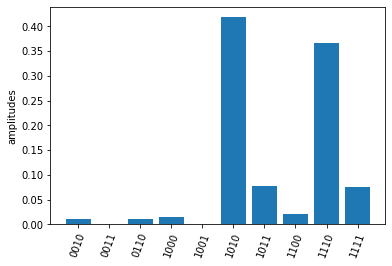

In [10]:

print(res.counts) #counts
print(res.amplitudes) #amplitude
res.plot_amplitudes()

If you want to check the correctness the execute results. Quafu provide simple circuit similator based on sparse matrix.

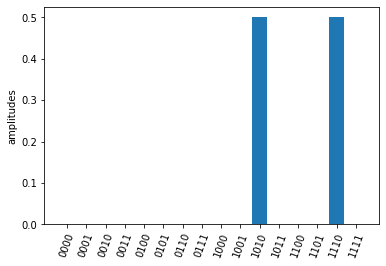

In [15]:
from quafu import simulate
simu_res = simulate(q, output="amplitudes")
simu_res.plot_amplitudes(full=True)

You can also submit the 4-bit ghz circuit `qc` built from openqasm.

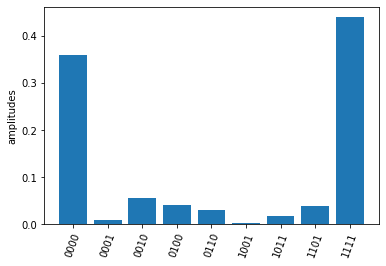

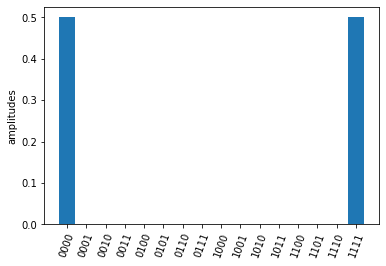

In [12]:
res = task.send(qc)
res.plot_amplitudes()

simu_res = simulate(qc)
simu_res.plot_amplitudes(full=True)

If you don't want to plot the results for basis with zero amplitudes, set the parameter `full` in method [`plot_amplitudes`](apiref/#quafu.results.results.SimuResult.plot_amplitudes) to False. Note that this parameter is only valid for results returned by simulator.  

## Submit circuit and measure observables

Quafu provides measuring observables with an excuted quantum circuit. You can input Pauli operators that need to measure expectation values to the [`submit`](apiref/#quafu.tasks.tasks.Task.submit) method.
For example, you can input [["XYX", [0, 1, 2]], ["Z", [1]]] to calcuate the expectation of operators $\sigma^x_0\sigma^y_1\sigma^x_2$ and $\sigma^z_1$.
The [`submit`](apiref/#quafu.tasks.tasks.Task.submit) method will minimize the executing times of the circuit with different measurement basis that can calculate all expectations of input operators. 

Here we show how to measure the energy expection of the Ising chain
$$H=\sum_i \sigma^z_i \sigma^z_{i+1} + g \sum_i \sigma^x_i.$$

First we initialize a circuit with three Hadamard gate

In [7]:
q = QuantumCircuit(5)

for i in range(5):
    if i % 2 == 0:
        q.h(i)

q.draw_circuit()
measures = list(range(5))
q.measure(measures)


q[0]  --H-- M->c[0]
           
q[1]  ----- M->c[1]
           
q[2]  --H-- M->c[2]
           
q[3]  ----- M->c[3]
           
q[4]  --H-- M->c[4]


Next we set operators that need to be measured to calculate the energy expectation, and submit the circuit using [`submit`](apiref/#quafu.tasks.tasks.Task.submit) method

In [8]:
test_Ising = [["X", [i]] for i in range(5)]
test_Ising.extend([["ZZ", [i, i+1]] for i in range(4)])
res, obsexp = task.submit(q, test_Ising)

Job start, need measured in  [['XXXXX', [0, 1, 2, 3, 4]], ['ZZZZZ', [0, 1, 2, 3, 4]]]


The function return measurement results and operator expectations. The measurement results only contain two ExecResult object since the circuit is only executed twice, with measurement basis  [['XXXXX', [0, 1, 2, 3, 4]] and ['ZZZZZ', [0, 1, 2, 3, 4]]] respectively.

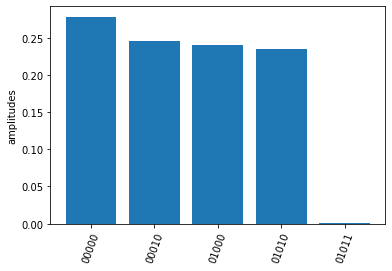

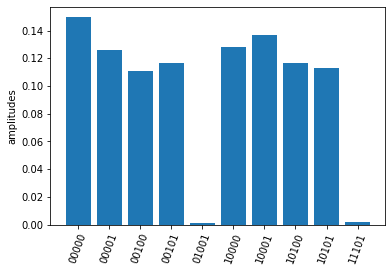

In [9]:

res[0].plot_amplitudes()
res[1].plot_amplitudes()


The return operator expectations (`obsexp`) is a list with a length equal to the input operator number. We can use it to calculate the energy expectation 

In [10]:
print(obsexp)
g = 0.5
E = g*sum(obsexp[:5])+sum(obsexp[5:])
print(E)


[1.0, 0.046999999999999986, 1.0, 0.03699999999999998, 0.998, 0.00899999999999995, 0.08499999999999996, 0.08299999999999996, 0.008999999999999952]
1.7269999999999999


## Submit task asynchronously
In the above examples, you have to wait for the result to return and cannot do other jobs continually. Now you can choose to set the parameter `wait` in [`send`](apiref/#quafu.tasks.tasks.Task.send) function to `false` to submit the task asynchronously and do not need it to return. When you need, you can retrieve the results at any time and check the status using the [`retrieve`](apiref/#quafu.tasks.tasks.Task.retrieve) function. Here, we use the example that measuring the qubit decoherence time $T_1$ to show the detailed usage.

First initial a task

In [5]:
task = Task()
task.load_account()
task.config(backend="ScQ-S10", shots=2000, compile=False, priority=2)

Prepare parameters of a group of tasks and send the task asynchronously.

In [6]:
ts = range(0, 21, 1)
names = ["%dus" %t for t in ts]
for name, t in zip(names, ts): 
    q = QuantumCircuit(3)
    q.x(2)
    q.delay(2, t, unit="us")
    q.measure([2])
    res = task.send(q, wait=False, name=name, group="Q3_T1")


Here the `delay` options will idle the target qubit `2` for a duration `t` in the time unit `us`(microsecond) and do nothing. In the send function, we set `wait` too false to execute the task asynchronously, give each task a name by duration time and set all tasks to a group named "Q3_T1".

Now we can try to retrieve the group of tasks using the [`retrieve_group`](apiref/#quafu.tasks.tasks.Task.retrieve_group) method.

In [8]:
group_res = task.retrieve_group("Q3_T1")
amps = [res.amplitudes["1"] for res in group_res]

Group:  Q3_T1
task_id              task_name      status    
1663B8202B410F1E     0us            Completed 
1663B83000D833A8     1us            In Queue  
1663B830074079CF     2us            In Queue  
1663B8300B951E51     3us            In Queue  
1663B8300FF78259     4us            In Queue  
1663B83014701227     5us            In Queue  
1663B830192FB161     6us            In Queue  
1663B8301DD58707     7us            In Queue  
1663B8302F0B6560     8us            Running   
1663B83033790C37     9us            Completed 
1663B83038996527     10us           Completed 
1663B84002C09ECE     11us           In Queue  
1663B840078B2AE8     12us           In Queue  
1663B84019A9B7A8     13us           In Queue  
1663B8401E3D0EF1     14us           In Queue  
1663B84022BFF72E     15us           In Queue  
1663B840277610E7     16us           In Queue  
1663B8402BFA740F     17us           In Queue  
1663B84031D4E5A0     18us           In Queue  
1663B840364C8B0E     19us           In Queue  

In [13]:
group_res = task.retrieve_group("Q3_T1")
amps = [res.amplitudes["1"] for res in group_res]

Group:  Q3_T1
task_id              task_name      status    
1663B8202B410F1E     0us            Completed 
1663B83000D833A8     1us            Completed 
1663B830074079CF     2us            Completed 
1663B8300B951E51     3us            Completed 
1663B8300FF78259     4us            Completed 
1663B83014701227     5us            Completed 
1663B830192FB161     6us            Completed 
1663B8301DD58707     7us            Completed 
1663B8302F0B6560     8us            Completed 
1663B83033790C37     9us            Completed 
1663B83038996527     10us           Completed 
1663B84002C09ECE     11us           Completed 
1663B840078B2AE8     12us           Completed 
1663B84019A9B7A8     13us           Completed 
1663B8401E3D0EF1     14us           Completed 
1663B84022BFF72E     15us           Completed 
1663B840277610E7     16us           Completed 
1663B8402BFA740F     17us           Completed 
1663B84031D4E5A0     18us           Completed 
1663B840364C8B0E     19us           Completed 

Once all tasks are completed, we can do the next step to get $T_1$.

Text(16, 0.9, '$T_1=19.69 \\mu s$')

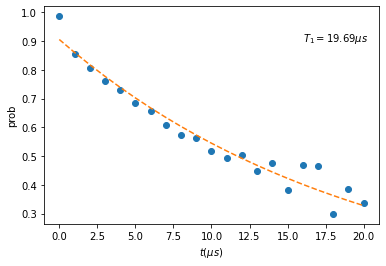

In [18]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
def func(x, a, b):
    return a*np.exp(-b*x)

paras, pconv = curve_fit(func, ts, amps)
plt.plot(ts, amps, "o")
plt.plot(ts, func(ts, *paras), "--")
plt.xlabel("$t (\mu s)$")
plt.ylabel("prob")
plt.text(16, 0.9, r"$T_1=%.2f \mu s$" %(1/paras[1]))

Note that task retrieving relies on the submit history saved in the `task` object. If your `task` object is changed or detroyed in the memory, you may get the wrong results. Suppose you have to close your program after submitting tasks, you need first save the history associated to the `task` object.

In [19]:
old_history = task.get_history() #get the history of task
#save the history to disk if you need!
#do save...

#retrieve the result using the `history` parameter with any Task() object
#do load...
newtask = Task()
newtask.load_account()
group_res = newtask.retrieve_group("Q3_T1", history=old_history)

Group:  Q3_T1
task_id              task_name      status    
1663B8202B410F1E     0us            Completed 
1663B83000D833A8     1us            Completed 
1663B830074079CF     2us            Completed 
1663B8300B951E51     3us            Completed 
1663B8300FF78259     4us            Completed 
1663B83014701227     5us            Completed 
1663B830192FB161     6us            Completed 
1663B8301DD58707     7us            Completed 
1663B8302F0B6560     8us            Completed 
1663B83033790C37     9us            Completed 
1663B83038996527     10us           Completed 
1663B84002C09ECE     11us           Completed 
1663B840078B2AE8     12us           Completed 
1663B84019A9B7A8     13us           Completed 
1663B8401E3D0EF1     14us           Completed 
1663B84022BFF72E     15us           Completed 
1663B840277610E7     16us           Completed 
1663B8402BFA740F     17us           Completed 
1663B84031D4E5A0     18us           Completed 
1663B840364C8B0E     19us           Completed 

Finally, you can also retrieve a single task using its unique `task_id`.

In [20]:
res_0us = newtask.retrieve(old_history["Q3_T1"][0])
print(res_0us.amplitudes)

{'0': 0.014, '1': 0.986}
